# Faires Machine Learning
Machine Learning Models werden bei ihrer Erschaffung auf Qualität überprüft - z.B. wird geprüft wie hoch der Anteil korrekter Vorhersagen ist (= accuracy). Man kann die Qualität jedoch noch detailierter betrachten. Wenn wir "Fairness" als Qualitätskriterium prüfen sprechen wir von einem "Fairness Audit". Ein solcher Fairness Audit wird in diesem Notebook an Hand eines Logistic Regression Models für Kreditwürdigkeit demonstriert.


**Aufgabe**:
Vollziehe die vorgestellten Schritte nach und erledige dann die am Ende gestellten Reflektionsaufgaben. Wenn du noch Zeit hast, versuche dich an der Übungsaufgabe.

---

## Logistische Regression: Ist eine Person kreditwürdig?

Banken wollen Kredite nur an Personen vergeben, die auch kreditwürdig sind. Dafür bauen wir ein Modell, das mit Hilfe von Logistic Regression einschätzt,
ob eine Person kreditwürdig ist. Dieses beispielhafte Modell können wir später auf Fairness überprüfen.

### Vorbereitung

Zunächst wird das verwendete Datenset "german_credit.csv" importiert. Dabei werden nur einige Spalten importiert, da das Modell zu diesem Übungszweck sehr simpel gehalten werden soll. Wir verwenden zur Datenverarbeitung die Bibliothek "pandas". Mit "pandas" kann man tabellarische Daten verarbeiten.

- [Dokumentation des Datensets](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data))
- [Dokumentation Pandas](https://pandas.pydata.org/docs/reference/index.html)

Die kategorischen Werte wurden im german_credit.csv bereits in Zahlen umgewandelt. Hier eine kurze Erklärung des Mappings Zahle -> Kategorie pro kategorischer Spalte.

- "Sex & Marital Status":
   - 1: male & separated
   - 2: female & separated
   - 3: male & single
   - 4: male & married/widowed
   - 5: female & single (nicht im Datenset enthalten)
- "Value Savings/Stocks"
   - 1:  ... < 100 DM
   - 2:  100 <= ... < 500 DM
   - 3:  500 <= ... < 1000 DM
   - 4:  .. >= 1000 DM
   - 5: unknown/ none
- "Payment Status of Previous Credit"
   -  0: no credits taken/ all credits paid back duly
    - 1: all credits at this bank paid back duly
    - 2: existing credits paid back duly till now
    - 3: delay in paying off in the past
    - 4: critical account/ other credits existing (not at this bank)

In [1]:
import pandas as pd
import numpy as np

demographics = ["No of dependents", "Sex & Marital Status"] # These columns will be used for the fairness audit - we will check whether the model is fair towards people with a different number of dependents, and whether it is fair towards people of different sex
features = ["Value Savings/Stocks", "Payment Status of Previous Credit", "Duration of Credit (month)", "Account Balance"] # These columns will be the features for our logistic regression model - we keep it simple for this exercise!
target = ["Creditability"] # The model should try to predict creditability - that means it classifies each instance in the data set as either creditable or not creditable

d = pd.read_csv("german_credit.csv", usecols=np.concatenate([demographics, features, target])) # import the CSV

d.head() # show a few rows of the imported data set

,Creditability,Account Balance,Duration of Credit (month),Payment Status of Previous Credit,Value Savings/Stocks,Sex & Marital Status,No of dependents
0,1,1,18,4,1,2,1
1,1,1,9,4,1,3,2
2,1,2,12,2,2,2,1
3,1,1,12,4,1,3,2
4,1,1,12,4,1,3,1


In [2]:
# We pre-process the "Sex & Marital Status" column to retrieve only the sex of a person, not their marital status.

d["female"] = (d["Sex & Marital Status"] == 2) | (d["Sex & Marital Status"] == 5) # is the person female?
d["female"] = d["female"].astype(int) # 1 = female, 0 = male
d = d.drop("Sex & Marital Status", axis=1) # Remove the column we retrieved the information from since we don't need it anymore
demographics = [demographics[0], "female"] # Update our demographics list

d.describe()

,Creditability,Account Balance,Duration of Credit (month),Payment Status of Previous Credit,Value Savings/Stocks,No of dependents,female
count,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000
mean,0.700000,2.577000,20.903000,2.54500,2.105000,1.155000,0.310000
std,0.458487,1.257638,12.058814,1.08312,1.580023,0.362086,0.462725
min,0.000000,1.000000,4.000000,0.00000,1.000000,1.000000,0.000000
25%,0.000000,1.000000,12.000000,2.00000,1.000000,1.000000,0.000000
50%,1.000000,2.000000,18.000000,2.00000,1.000000,1.000000,0.000000
75%,1.000000,4.000000,24.000000,4.00000,3.000000,1.000000,1.000000
max,1.000000,4.000000,72.000000,4.00000,5.000000,2.000000,1.000000


### Logistic Regression

Jetzt trainieren wir ein out-of-the-box Logistic Regression Model mit Hilfe von "sklearn". Die Bibliothek "sklearn" kann verschiedene Machine Learning Aufgaben übernehmen.

- [Dokumentation sklearn](https://scikit-learn.org)

In [3]:
from sklearn.model_selection import train_test_split

x = d[features + demographics] # x = all columns of the data set that are features or demographics
y = np.ravel(d[target].values) # y = the target column of the data set (as a 1d array)

x_train_with_demographics, x_test_with_demographics, y_train, y_test = train_test_split(x, y, test_size=0.2) # sklearn can do the train-test split for us

In [4]:
# We remove the demographics for the training and add them back later on for the fairness audit
X_train = x_train_with_demographics[features]
X_test = x_test_with_demographics[features]

In [5]:
from sklearn.linear_model import LogisticRegressionCV

model = LogisticRegressionCV()
model.fit(X_train, y_train) # Train the logistic regression model on the training instances

y_pred = model.predict(X_test) # Classify the test instances

## Einschätzung der Model Qualität

Nachdem wir nun beispielhaft ein Logistic Regression Model zur Vorhersage der Kreditwürdigkeit trainiert haben, können wir nun seine Qualität einschätzen.

### Qualität allgemein und pro Klasse

Wir werfen einen Blick auf den Report, den sklearn uns generiert. Er enthält die folgenden Metriken:
- [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall) pro target Klasse
    - "precision" = Von allen Instanzen, die in diese Klasse eingeordnet wurden: Wieviele gehören tatsächlich in diese Klasse?
    - "recall" = Von allen Instanzen, die tatsächlich in diese Klasse gehören: Wieviele wurden in diese Klasse eingeordnet?
- [f1-score](https://en.wikipedia.org/wiki/F-score) pro target Klasse (= harmonisches Mittel von precision und recall)
- accuracy (= Klassenunabhängig: Rate der korrekten Klassifizierungen)
- die obigen Metriken werden außerdem als Mittelwerte über beide Klassen gegeben
    - "macro" = ungewichtetes Mittel
    - "weighted" = gewichtetes Mittel
- "support" = Anzahl von Instanzen dieser Klasse in y_test

Siehe auch: [classification_report documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report)

In [6]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, target_names=["not creditable", "creditable"])
print(report)

                precision    recall  f1-score   support

not creditable       0.67      0.41      0.51        54
    creditable       0.81      0.92      0.86       146

      accuracy                           0.79       200
     macro avg       0.74      0.67      0.68       200
  weighted avg       0.77      0.79      0.77       200



### Fairness

Fairness ist ebenfalls ein Qualitätsfaktor für Machine Learning Modelle. Während es viele Definitionen für Fairness gibt, ist die allgemeine Frage, die dieser Faktor stellt: Funktioniert das Modell gleich gut für alle Gruppen? Diese Frage enthält drei separate Aspekte: "gleich", "gut" und "Gruppen".

"Gut" bezieht sich auf Qualitäts-Metriken, die aus der [Confusion Matrix](https://en.wikipedia.org/wiki/Confusion_matrix) (True Positives, False Positives, True Negatives und False Negatives) berechnet werden - die Auswahl erfolgt je nach verwendeter Fairness-Definition (siehe [Verma & Rubin 2018](https://fairware.cs.umass.edu/papers/Verma.pdf)). Es muss je nach Fall entschieden werden, welche Fairness-Definitionen relevant sind.

Es muss außerdem von Fall zu Fall entschieden werden, wie "gleich" die Qualität für verschiedene Gruppen sein muss, damit das Modell fair ist. Die Gleichheit der Qualitäts-Metriken pro Gruppe wird entweder durch die Differenz oder das Verhältnis bestimmt.

Letztenendes muss auch noch ausgewählt werden, für welche "Gruppen" Fairness geprüft wird. Gruppen können z.B. nach demographischen Eigenschaften wie Geschlecht oder Alter gebildet werden.

Wir können die Bibliothek "fairlearn" benutzen, um einige Qualitäts-Metriken pro Gruppe für das Modell berechnen zu lassen.

- [Fairlearn User Guide](https://fairlearn.org/v0.8/user_guide/)
- [Fairlearn Dokumentation](https://fairlearn.org/v0.8/api_reference/index.html)

#### Auswahl von Fairness-Definitionen

Bei unserem Use Case handelt sich um die Vorhersage von Kreditwürdigkeit.

Wir wollen folgende Fairness-Definitionen prüfen (nach [Verma & Rubin 2018](https://fairware.cs.umass.edu/papers/Verma.pdf)):
- Predictive Equality (gleiche FPR) = In verschiedenen Gruppen werden ähnlich viele Personen fälschlicherweise als kreditwürdig eingestuft und erhalten damit eine Chance auf einen Kredit
- Equal Opportunity (gleiche FNR) = In verschiedenen Gruppen werden ähnlich viele Personen fälschlicherweise als kreditunwürdig eingestuft und erhalten damit nicht die Chance auf einen Kredit
- Overall Accuracy Equality (gleiche accuracy)

In [8]:
from sklearn.metrics import accuracy_score
!pip install fairlearn
from fairlearn.metrics import MetricFrame, count, false_negative_rate, false_positive_rate

metrics = {
    "accuracy": accuracy_score,
    "false positive rate": false_positive_rate, # for predictive parity
    "false negative rate": false_negative_rate, # for equal opportunity
    "count": count, # how many instances belong to this group?
}

     -------------------------------------- 235.0/235.0 kB 3.6 MB/s eta 0:00:00


#### Berechnung der Fairness-Metriken

Wir lassen nun von fairlearn die ausgewählten Metriken berechnen und anzeigen.

array([[<Axes: title={'center': 'accuracy'}, xlabel='No of dependents'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='No of dependents'>,
        <Axes: title={'center': 'false negative rate'}, xlabel='No of dependents'>,
        <Axes: title={'center': 'count'}, xlabel='No of dependents'>]],
      dtype=object)

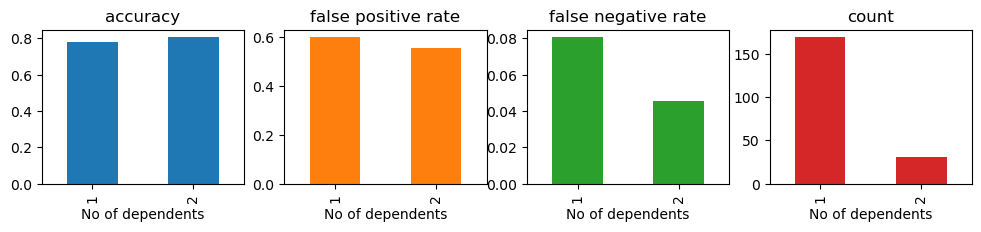

In [9]:
sensitive_feature_0 = x_test_with_demographics[demographics[0]] # Number of dependents
m_0 = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_feature_0)

m_0.by_group.plot.bar(
    subplots=True,
    layout=[1, 4],
    legend=False,
    figsize=[12, 2]
)

array([[<Axes: title={'center': 'accuracy'}, xlabel='female'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='female'>,
        <Axes: title={'center': 'false negative rate'}, xlabel='female'>,
        <Axes: title={'center': 'count'}, xlabel='female'>]], dtype=object)

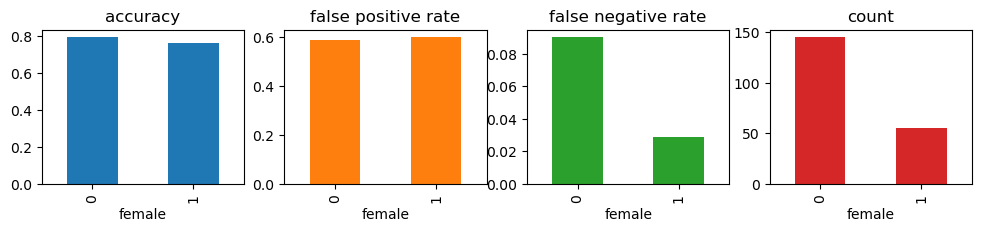

In [10]:
sensitive_feature_1 = x_test_with_demographics[demographics[1]] # female
m_1 = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_feature_1)

m_1.by_group.plot.bar(
    subplots=True,
    layout=[1, 4],
    legend=False,
    figsize=[12, 2]
)

#### Sind die Modelle gleich gut?

Wir haben nun beobachtet, wie akkurat die Modelle pro Gruppe sind, und wie hoch die Fehlerraten sind. Doch sind diese Metriken ähnlich genug, damit die von uns ausgewählten Fairness-Definitionen erfüllt werden? Reminder, unsere Definitionen sind:

- Predictive Equality (gleiche FPR)
- Equal Opportunity (gleiche FNR)
- Overall Accuracy Equality (gleiche accuracy)

Die Ähnlichkeit kann man nun entweder mit der Differenz oder der Rate (Anteil) berechnen. Fairlearn übernimmt auch diese Aufgabe für uns. Welche Differenz oder Rate man als "zu hoch" einstuft muss man selber festlegen, da es hierzu noch keine Standards gibt.

In [11]:
m_0.difference() # Number of dependents

accuracy                 0.025387
false positive rate      0.044444
false negative rate      0.035191
count                  138.000000
dtype: float64

In [12]:
m_0.ratio() # Number of dependents

accuracy               0.968521
false positive rate    0.925926
false negative rate    0.563636
count                  0.183432
dtype: float64

In [13]:
m_1.difference() # female?

accuracy                0.029467
false positive rate     0.011765
false negative rate     0.061519
count                  90.000000
dtype: float64

In [14]:
m_1.ratio() # female?

accuracy               0.962846
false positive rate    0.980392
false negative rate    0.317143
count                  0.379310
dtype: float64

#### Intersektionale Gruppen

In der Fairness-Forschung hat man herausgefunden, dass Diskriminierung sich oft "aufaddiert". D.h. wenn man beobachten kann dass z.B. People of Color diskriminiert werden und Frauen diskriminiert werden, dass dann Women of Color besonders stark diskriminiert werden. "Women of Color" ist eine intersektionale Guppe. Wir prüfen daher außerdem noch, wie gut unser Modell für die verschiedenen intersektionalen Gruppen funktioniert.

array([[<Axes: title={'center': 'accuracy'}, xlabel='No of dependents,female'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='No of dependents,female'>,
        <Axes: title={'center': 'false negative rate'}, xlabel='No of dependents,female'>,
        <Axes: title={'center': 'count'}, xlabel='No of dependents,female'>]],
      dtype=object)

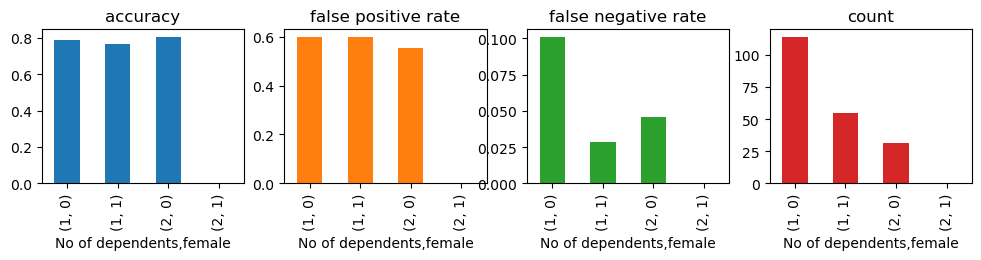

In [15]:
sensitive_features = x_test_with_demographics[demographics] # both demographics: number of dependents and female
m = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_features)

m.by_group.plot.bar(
    subplots=True,
    layout=[1, 4],
    legend=False,
    figsize=[12, 2]
)

In [16]:
m.difference()

accuracy                0.042815
false positive rate     0.044444
false negative rate     0.072552
count                  83.000000
dtype: float64

In [17]:
m.ratio()

accuracy               0.946909
false positive rate    0.925926
false negative rate    0.282540
count                  0.271930
dtype: float64

## Reflektionsaufgaben

- Würdest du das Modell als fair, oder als unfair einschätzen?
- Woran liegen womöglich die Unterschiede in Accuracy und Fehlerraten
   - zwischen verschiedenen Klassen?
   - zwischen verschiedenen (intersektionalen) Gruppen?
- Hast du eine Idee, wie man versuchen könnte die Unterschiede anzugleichen?

## Übungsaufgabe
- Nutze die hier vorgestellten Methoden (soweit möglich) um dein eigenes Klassifizierungsmodell (aus einer früheren Übung in diesem Kurs) zu testen